In [37]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.cluster import KMeans

import tarfile
import altair as alt
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [38]:
df = pd.read_csv('../../data/final_dataset.csv').drop(columns = ['Unnamed: 0'])

In [39]:
df.columns

Index(['Watch Status', 'Phone Brand', 'Diagnosis', 'Gender', 'Study ID',
       'LAMP ID', 'Race', 'Age', 'DOB', 'Date of Consent',
       'gps_data_quality_mean', 'gps_data_quality_var', 'hometime_mean',
       'hometime_var', 'entropy_mean', 'entropy_var', 'screen_duration_mean',
       'screen_duration_var', 'internal_sleep_mean', 'internal_sleep_var',
       'PHQ-2_mean', 'PHQ-2_var', 'GAD-2_mean', 'GAD-2_var'],
      dtype='object')

In [40]:
df = df[['LAMP ID', 'Diagnosis', 'gps_data_quality_mean', 'gps_data_quality_var', 'GAD-2_mean', 
         'GAD-2_var', 'PHQ-2_mean', 'PHQ-2_var',
  'hometime_mean', 'hometime_var', 'entropy_mean', 'screen_duration_mean', 'screen_duration_var',
       'entropy_var', 'internal_sleep_mean', 'internal_sleep_var']].fillna(df.mean())

<ipython-input-40-55c02f089f6e>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  'entropy_var', 'internal_sleep_mean', 'internal_sleep_var']].fillna(df.mean())


In [41]:
class_df = df.drop(['LAMP ID'], axis=1)

df_data = df.drop(['Diagnosis', 'LAMP ID'], axis=1)

In [42]:
df['Diagnosis'] = df['Diagnosis'].replace('Major Depressive Disorder','MDD')

In [43]:
df['Diagnosis'].unique()

array(['Bipolar II', 'MDD', 'Bipolar I', 'Control'], dtype=object)

In [44]:
# Scaling data to keep variables in the same range
from sklearn.preprocessing import StandardScaler

df_data[df_data.columns] = StandardScaler().fit_transform(df_data)

In [45]:
np.shape(df_data)

(78, 14)

In [46]:
df_data

,gps_data_quality_mean,gps_data_quality_var,GAD-2_mean,GAD-2_var,PHQ-2_mean,PHQ-2_var,hometime_mean,hometime_var,entropy_mean,screen_duration_mean,screen_duration_var,entropy_var,internal_sleep_mean,internal_sleep_var
0,0.261107,-0.519338,0.361654,-0.074279,0.452995,-0.315535,-1.107071,-0.900161,1.088946,0.558626,-0.645806,-0.282278,7.084947e-02,-1.333614e+00
1,-0.189262,1.495577,1.748260,0.381819,2.346386,-0.881280,-2.281705,-0.329551,1.680316,-0.748546,1.790554,-1.244164,7.702309e-16,3.026719e-16
2,-1.986233,1.617688,0.090588,-0.038903,0.132375,0.001815,-0.679102,0.650054,-0.413191,-0.739474,2.234073,1.855348,-1.488419e-01,-1.571727e+00
3,0.414162,0.179901,-0.123658,-0.298907,-0.456282,1.223607,0.332596,3.599544,1.258074,-2.058497,-0.343919,4.136288,7.702309e-16,3.026719e-16
4,0.501981,0.252657,1.302565,0.866424,1.298660,2.020696,0.782829,0.255049,0.601325,0.606225,0.896683,0.283070,1.182315e+00,1.883764e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,0.626061,-0.400600,-1.223038,-0.986476,-1.111111,-0.881280,0.243359,1.190775,0.095562,0.226191,0.807348,1.649247,-1.073497e+00,-4.607749e-01
74,0.844465,-0.781977,-0.866482,-0.110767,-0.957444,-0.655401,0.851960,-0.037108,-0.569024,1.183793,-0.677703,0.398978,-1.106707e+00,-2.922569e-01
75,-1.847085,0.486539,-1.223038,-0.986476,-1.111111,-0.881280,-0.922425,-0.810077,-0.506092,-1.194806,0.982680,0.403577,7.702309e-16,3.026719e-16
76,0.730241,-0.499903,-1.181578,-0.897673,-1.084308,-0.830055,1.175138,-0.299723,-0.677397,0.894494,0.008006,-0.284203,-1.394723e+00,-1.620079e+00


In [47]:
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

X = df_data

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa16df70940>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fa16df70940>
Traceback 

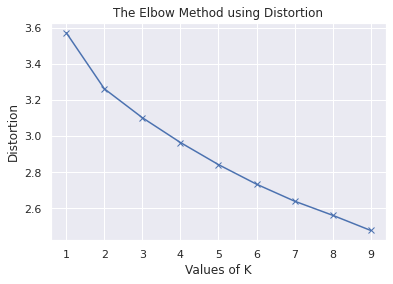

In [48]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [49]:
import kneed
kneedle = kneed.KneeLocator(x=K, 
                 y=inertias, 
                 curve='convex', 
                 direction='decreasing')

knee_point = kneedle.knee #elbow_point = kneedle.elbow
print('Knee: ', knee_point) #print('Elbow: ', elbow_point)
kneedle.plot_knee()

ModuleNotFoundError: No module named 'kneed'

In [50]:
kmeans = KMeans(n_clusters=3)    
kmeans.fit(df_data)

KMeans(n_clusters=3)

In [51]:
true_label_names = df['Diagnosis']
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform(true_label_names)

In [52]:
pca_2 = PCA(n_components=2)
pca_2_result = pca_2.fit_transform(df_data)

In [53]:
n_clusters = 4

preprocessor = Pipeline(
    [
       ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
     ]
)
dataset_pca = pd.DataFrame(abs(pca_2.components_), columns=df_data.columns, index=['PC_1', 'PC_2'])
print('\n\n', dataset_pca)
clusterer = Pipeline(
 [
(
           "kmeans",
      KMeans(
         n_clusters=n_clusters,
             init="k-means++",
                n_init=50,
             max_iter=500,
               random_state=42,
         ),
        ),
   ]
)
pipe = Pipeline(
 [
      ("preprocessor", preprocessor),
     ("clusterer", clusterer)
    ]
)
pipe.fit(df_data)
preprocessed_data = pipe["preprocessor"].transform(df_data)
predicted_labels = pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)



       gps_data_quality_mean  gps_data_quality_var  GAD-2_mean  GAD-2_var  \
PC_1               0.025924              0.142427    0.352925   0.335568   
PC_2               0.291452              0.311769    0.319204   0.169618   

      PHQ-2_mean  PHQ-2_var  hometime_mean  hometime_var  entropy_mean  \
PC_1    0.342247   0.329396       0.255058      0.291961      0.342147   
PC_2    0.393686   0.288466       0.422804      0.228046      0.265683   

      screen_duration_mean  screen_duration_var  entropy_var  \
PC_1              0.210815             0.109638     0.343791   
PC_2              0.001292             0.311279     0.187194   

      internal_sleep_mean  internal_sleep_var  
PC_1             0.044834            0.268736  
PC_2             0.122493            0.026377  


0.45645377813708193

In [54]:
adjusted_rand_score(true_labels, predicted_labels)

0.2654855633973194

/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


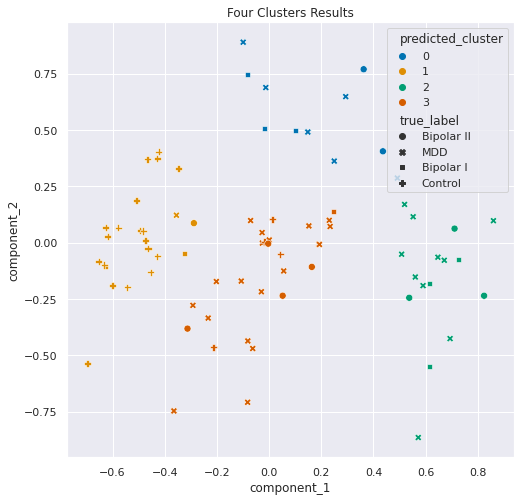

In [55]:
adjusted_rand_score(true_labels, predicted_labels)
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(df_data),
       columns=["component_1", "component_2"],
 )

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

#plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))
scat = sns.scatterplot(
     "component_1",
    "component_2",
    s=50,
        data=pcadf,
   hue="predicted_cluster",
    style="true_label",
    palette="colorblind",
 )

scat.set_title(
     "Four Clusters Results"
 )

sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

In [65]:
pcadf.columns = ['Component 1', 'Component 2', 'Predicted Cluster', 'True Label']

In [69]:
chart = alt.Chart(pcadf, title='4-Group Clustering').mark_point(filled=True, size=80, opacity=1).encode(
    x = alt.X('Component 1', title='Component 1', scale=alt.Scale(domain=(-1, 1), clamp=True)),
    y = alt.Y('Component 2', title='Component 2', scale=alt.Scale(domain=(-1, 1), clamp=True)),
    color = 'Predicted Cluster:N',
    shape = alt.Shape('True Label:N'),
    tooltip = ['Predicted Cluster', 'True Label']
).properties(width=500, height=500)

In [70]:
chart

alt.Chart(...)